# Krista, working on linking CO and KO
26 August 2015

The KEGG CO numbers from the RI data are not unique. In MATLAB, I have created a new value 'RInumber' which is an arbitrary number for each 'mzRT' feature. The data exported out of MATLAB include that number, the corresponding KEGG CO number, and whether the feature was observed in positive or negative ion mode. These data will be uesd to create a lookup table which allow use of the CO numbers or RInumbers as needed.

In [1]:
#%reset

In [2]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import palettable as pal
from itertools import chain

%matplotlib inline

This version is using metabolites which can have isomers in KEGG, but are only found in either positive or negative ion mode (haven't dealt with the metabolites found in both yet). 

Also, will need to export the following from MATLAB
(1) RInumber, (2) CO number, (3) ion mode information

Also, want to move some of my working files out of sight so they don't fill up GitHub. Need to figure out the best way to do that.'

In [3]:
mtabFile = 'RImetabolites_isomers.2015.08.27.csv' #first column is RInumber

In [4]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')
# CO_fromMATLAB=CO_RawData[CO_RawData.sum(axis=1)!=0]
#read in the data from MATLAB and take a quick look
CO_fromMATLAB.head(n=5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5
RInumber,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436


make the list of unique cNumbers here, do the KEGG thing and filter the list before I start splitting up the dataframes into data and metadata...

In [5]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

In [6]:
#wonder whether these should be defined at the top?
import os.path
import cPickle as cpk

This grabs the CO/KO links from the KEGG website. The actual code is in the CreateHash_COtoKO.py that Harriet wrote. Note that since the exportCOnumbers.csv file is a unique list of C number we essentially already have a lookup table for all the metabolites of interest.

In [7]:
# if os.path.isfile('exportCOnumbers.csv' + '.pickle'):
#     #just read in the file
#     WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))
# else:
#     #need to make the file
#     filename = "CreateHash_COtoKO.py"
#     %run $filename exportMetabolites.csv 
#     #then read in the file
#     WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))

WorkingFile = cpk.load(open('exportMetabolites.csv.pickle','r'))


In [8]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'



There are 307 COs with an associated KO. 1044 are not associated with a KO.


In [9]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

# KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
# CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()

In [10]:
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand 
#what is happening), then make a new column in CO_RawData_all that is True/False
CO_fromMATLAB['inList'] = ""

for idx in range(0,len(CO_fromMATLAB)):
# for idx in range(0):
    fc = CO_fromMATLAB.ix[idx,'cNumber']
    if fc in AllCO:
        CO_fromMATLAB.ix[idx,'inList'] = True
    else:
        CO_fromMATLAB.ix[idx,'inList'] = False  

In [11]:
CO_fromMATLAB.head(5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5,inList
RInumber,,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441,False
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False


In [12]:
#can't quite figure out how to do this in one step.
m = CO_fromMATLAB[CO_fromMATLAB['inList']==True]
CO_metadata_pruned = m.loc[:,['cNumber','ChargedMass','RT','ionMode']]

#this list of things came in handy, so define it up front. Actually want something that can't change 
#but had trouble getting a tuple to work as an index.
dayList = ['S1','S2','S3','S4','S5'] #this makes a list (mutable, can be changed)
#days = ('S1','S2','S3','S4','S5') #this makes a tuple (immutable)
CO_RawData_pruned = m.loc[:,dayList]
del m

This is the new version, with the extended metadata. Parse the file into data and metadata.

In [13]:
#read in the KO data
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]

Consider various data normalization options here. For now, normalize to mean and move one.

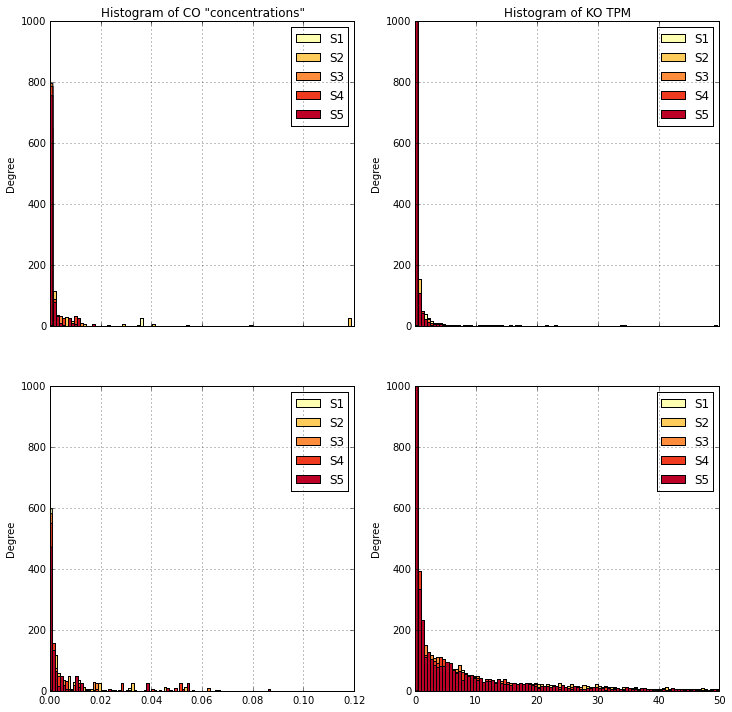

In [14]:
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData_pruned.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData_pruned.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])

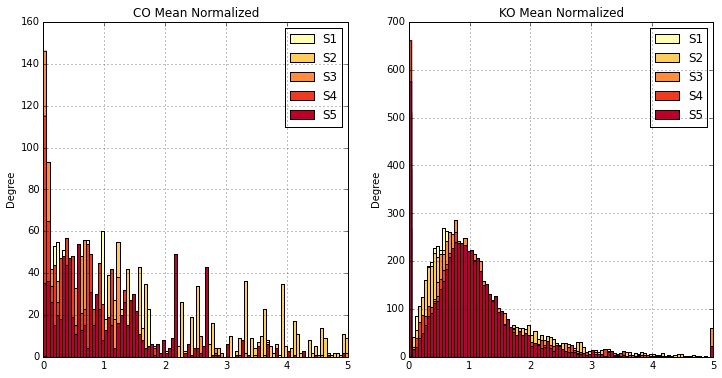

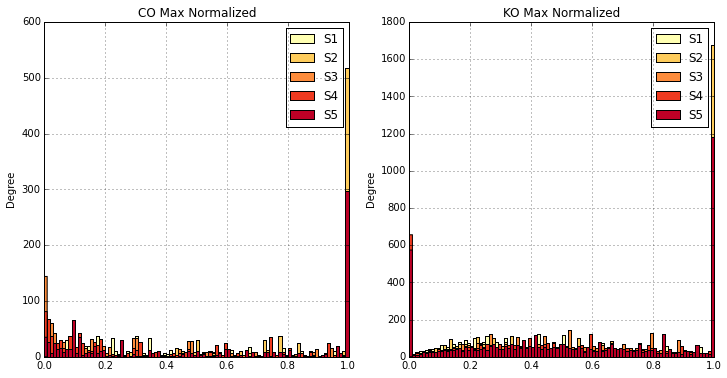

In [15]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out


def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

#several options for normalizing the data
CO_Norm2Mean=NormalizeToMean(CO_RawData_pruned) #this is what gets used in the original code
KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code
CO_Norm2Max=NormalizeToMax(CO_RawData_pruned)
KO_Norm2Max=NormalizeToMax(KO_RawData)

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])

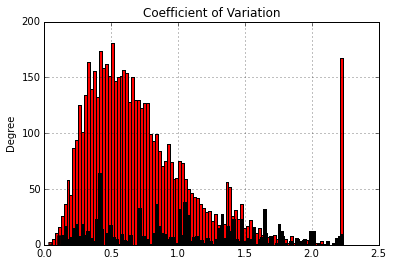

In [16]:
def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData_pruned)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')

In [17]:
KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
CO_limited_Norm2Mean = CO_Norm2Mean.dropna() #already 'limited' this before the normalization

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#this next line prints up some sort of pre-canned details about the program. 
print(__doc__) 

def kmeanCluster(data,nc):
    kmeans=KMeans(n_clusters=nc)
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):
    ssa = [] #can I put the silhoette average here?
    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
       
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
         #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        plt.show()
    
def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)


Automatically created module for IPython interactive environment


So...how do we actually decide how many clusters are best? Using silhouette analysis, looking for high silhouette_scores. For now I have set this to only look at a few options. However, there are also good silhouette scores with 2-5 clusters as well.

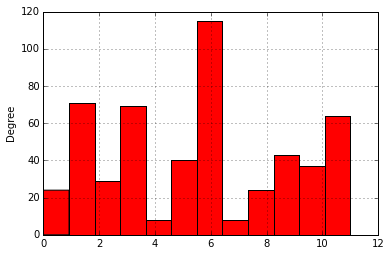

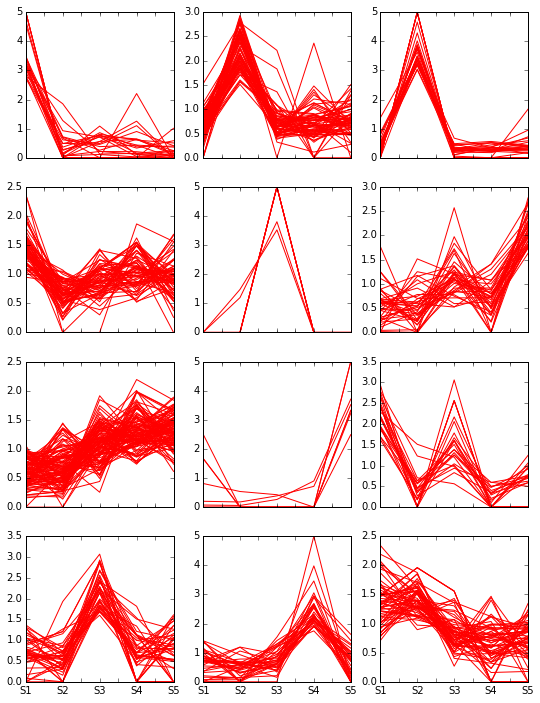

In [19]:
#run the Kmeans clustering on the KO data along first and plot results
#koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
#PlotKmeans(koClust,15,3,5, 'r') 
koClust=kmeanCluster(KO_limited_Norm2Mean, 12)
PlotKmeans(koClust,12,4,3, 'r') 

('For n_clusters =', 11, 'The average silhouette_score is :', 0.41235672668976786)


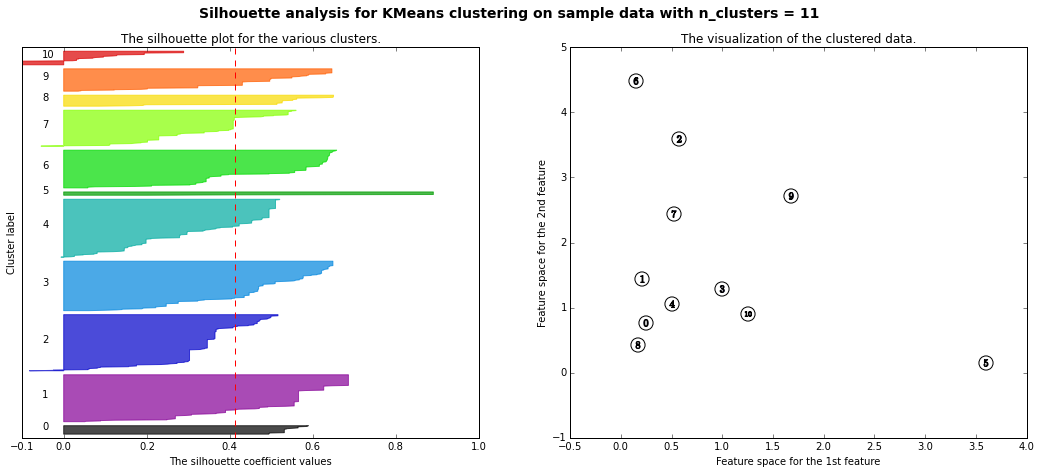

('For n_clusters =', 12, 'The average silhouette_score is :', 0.40301354188674243)


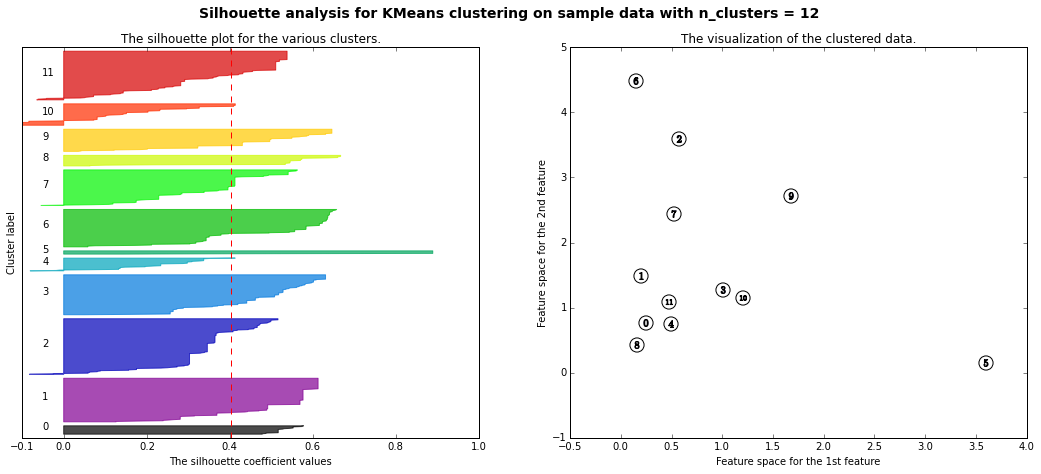

In [20]:
#now do the Kmeans clustering on the CO data
#silhoetteAnalysis(CO_limited_Norm2Mean, np.arange(2,20,1)) #KL trying a large range of options
silhoetteAnalysis(CO_limited_Norm2Mean.loc[:,(dayList)], np.arange(11,13,1))

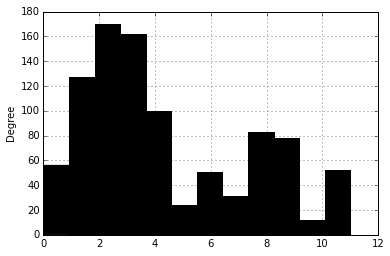

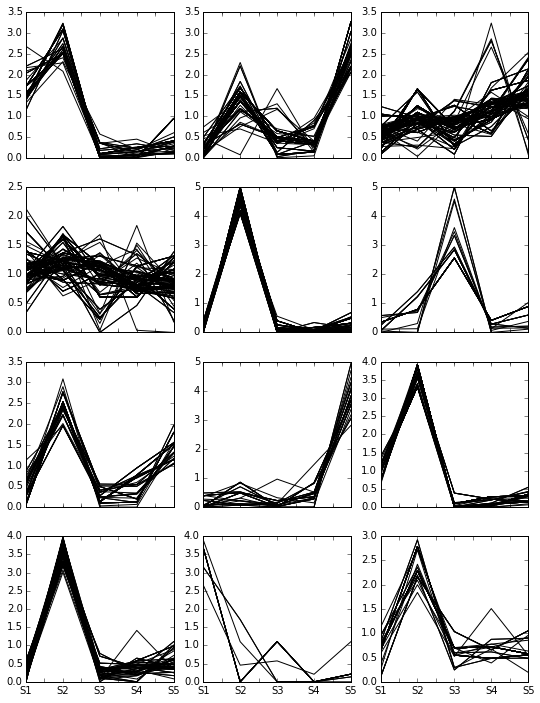

In [21]:
#plot up the results of one number of clusters for the CO data only
#coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
#PlotKmeans(coClust,15,3,5, 'k') 
coClust=kmeanCluster(CO_limited_Norm2Mean.loc[:,(dayList)], 12)
PlotKmeans(coClust,12,4,3, 'k') 

From HA: By normalizing the data to the mean we can then (in theory) combine the two and cluster them together?
KL 8/20/2015 note: this is essentially a list with the CO and KO concatenated into a single data frame. Note that the actual kmeans clustering does not happen until after the silhoette analysis.

Seems like it would be nice to save the silouette score and plot it against the number of clusters...but I got stuck on how to export the scores as a dataframe. The data are there since they are in the header...so, do this the hard way.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.43506986843849677)


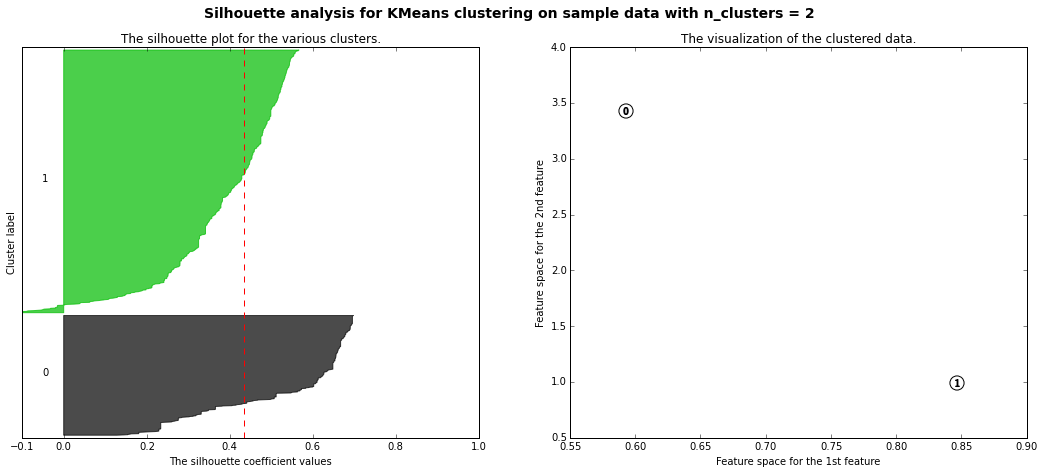

('For n_clusters =', 3, 'The average silhouette_score is :', 0.37465585195996748)


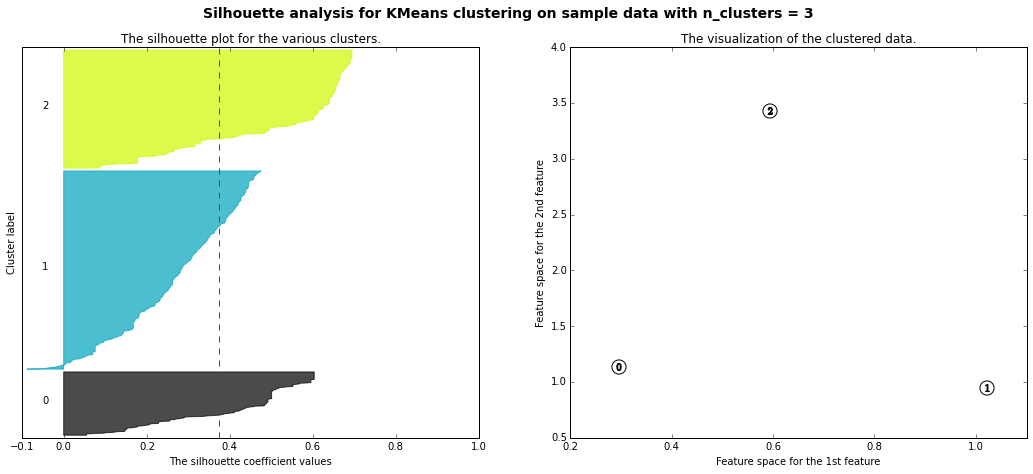

('For n_clusters =', 4, 'The average silhouette_score is :', 0.38764665694540856)


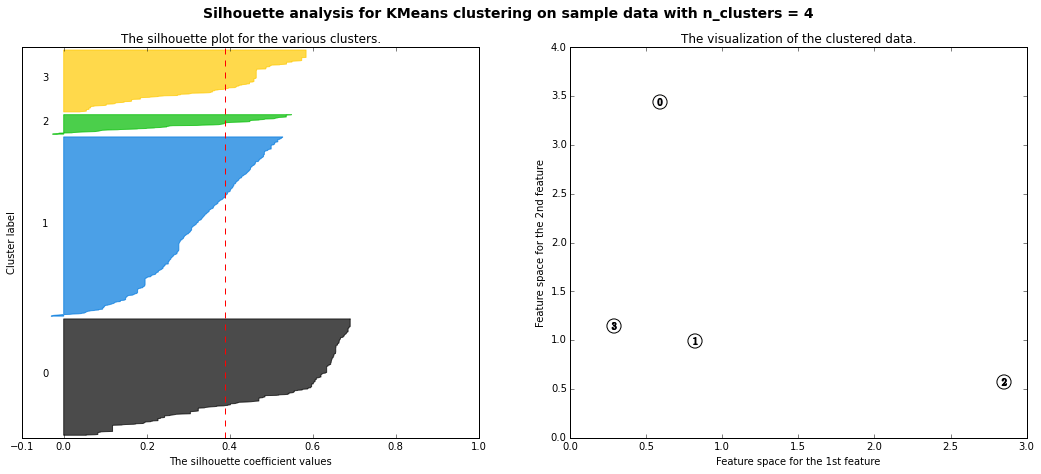

('For n_clusters =', 5, 'The average silhouette_score is :', 0.4044062472985791)


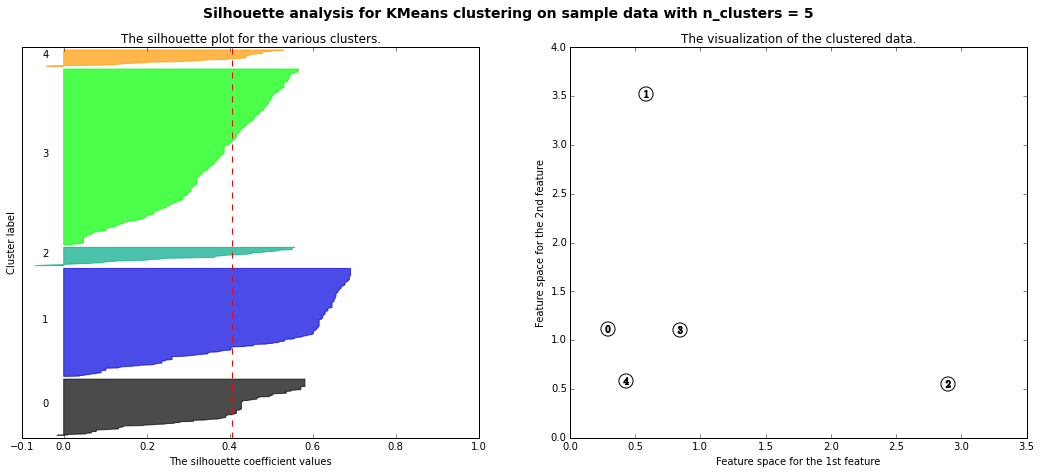

('For n_clusters =', 6, 'The average silhouette_score is :', 0.3678938513173442)


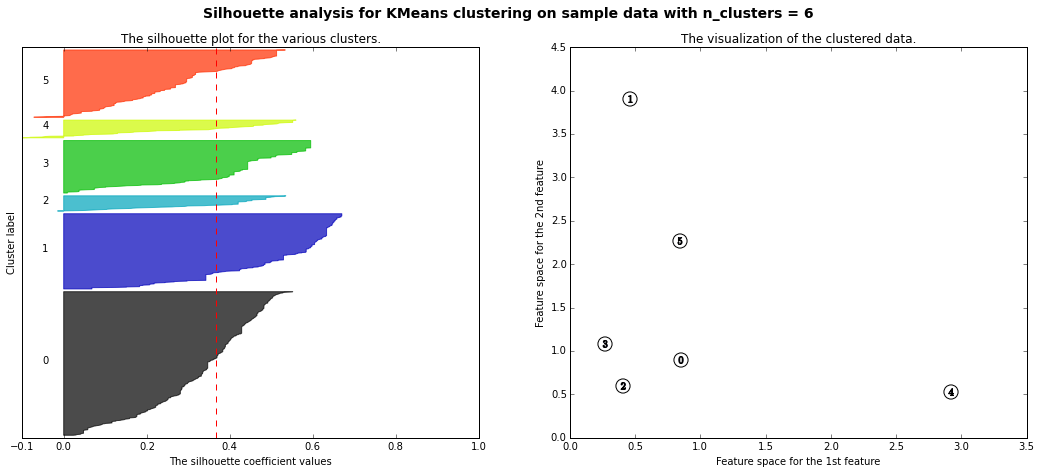

('For n_clusters =', 7, 'The average silhouette_score is :', 0.32778608806453535)


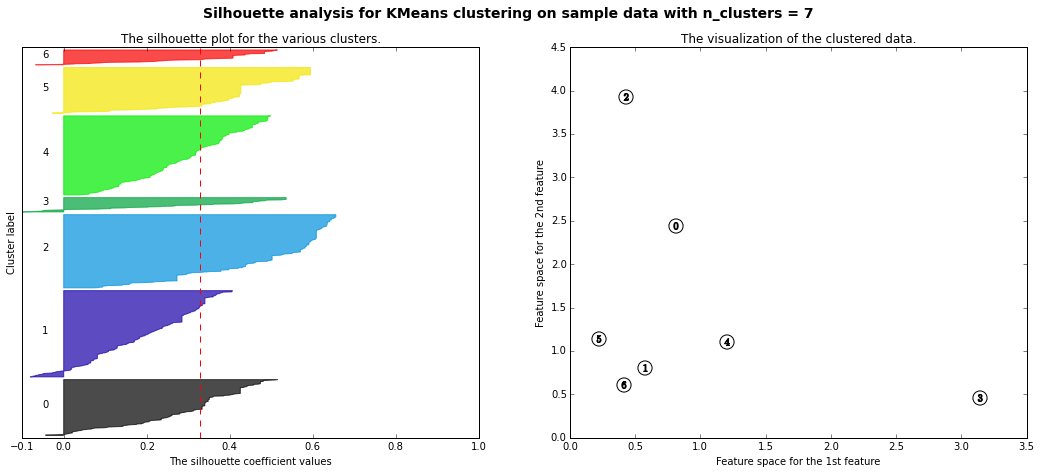

('For n_clusters =', 8, 'The average silhouette_score is :', 0.32676218728257489)


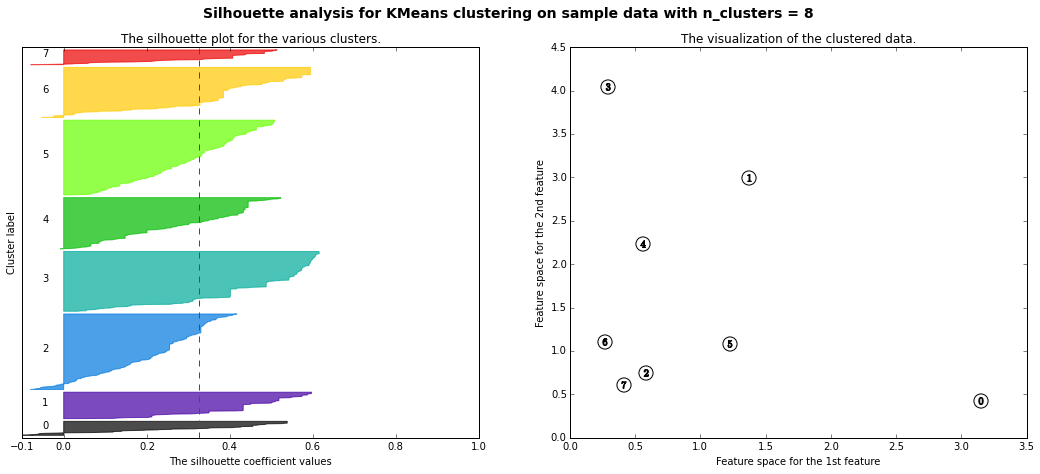

('For n_clusters =', 9, 'The average silhouette_score is :', 0.33508584595195962)


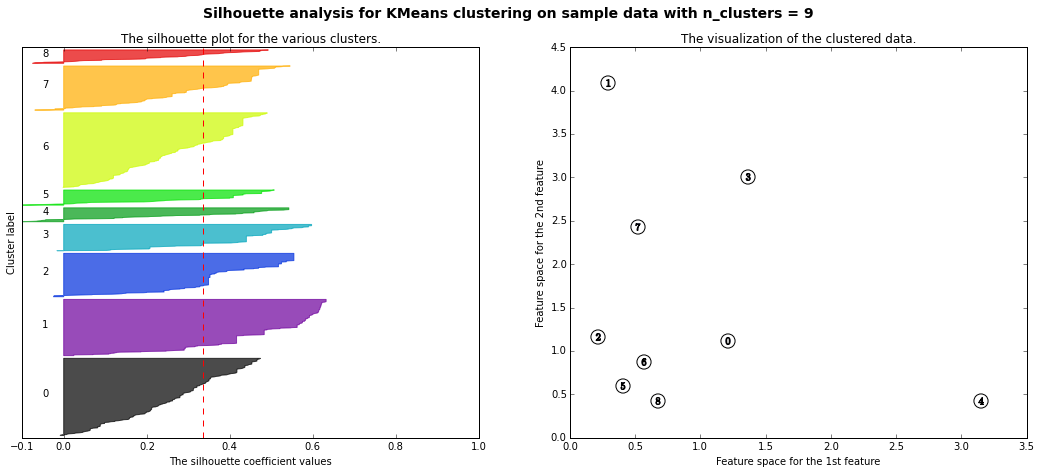

('For n_clusters =', 10, 'The average silhouette_score is :', 0.34111167443345752)


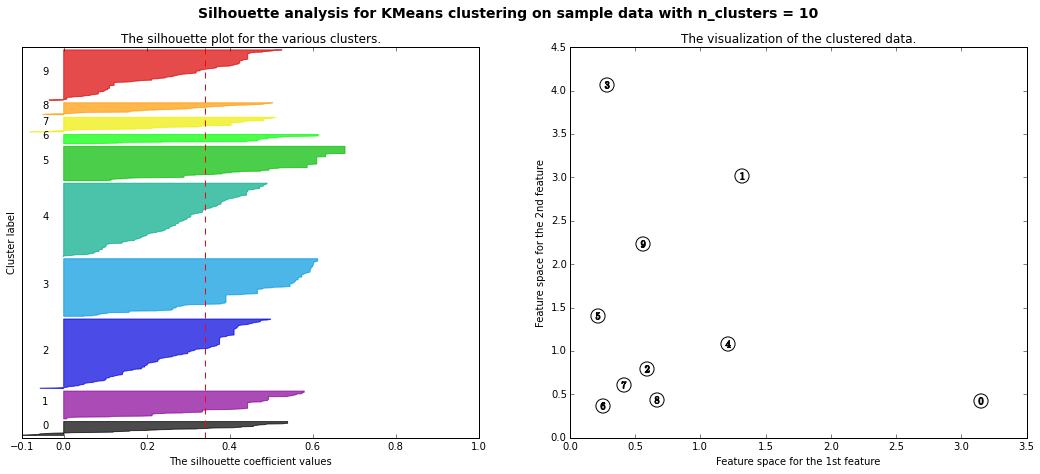

('For n_clusters =', 11, 'The average silhouette_score is :', 0.33638694451595724)


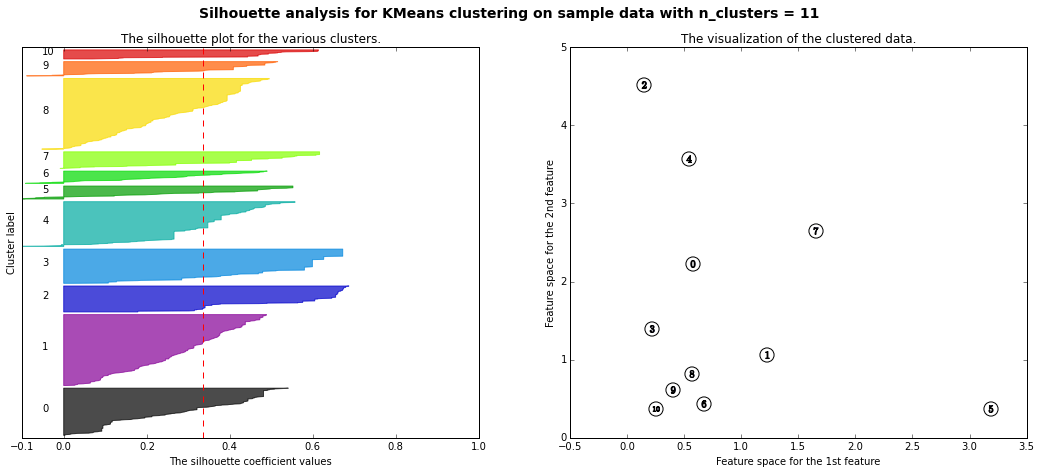

('For n_clusters =', 12, 'The average silhouette_score is :', 0.33392045190703118)


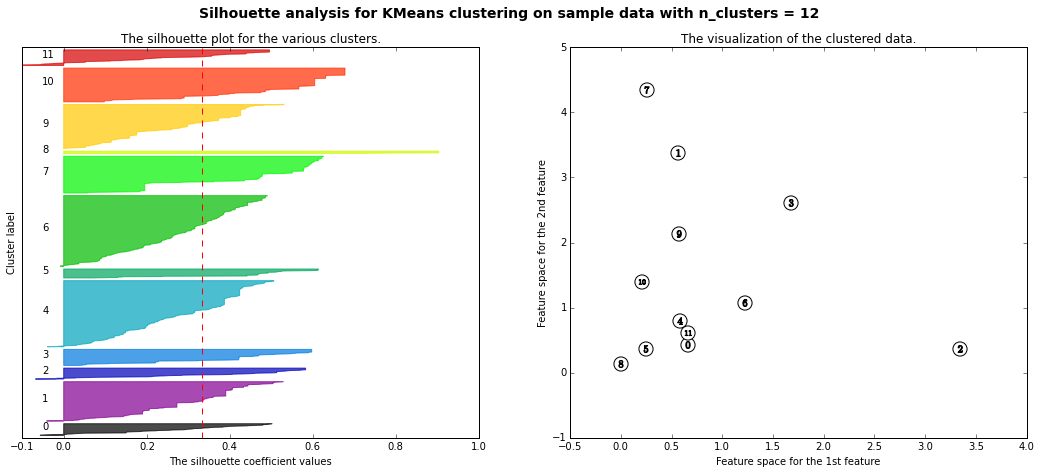

('For n_clusters =', 13, 'The average silhouette_score is :', 0.33101810635560081)


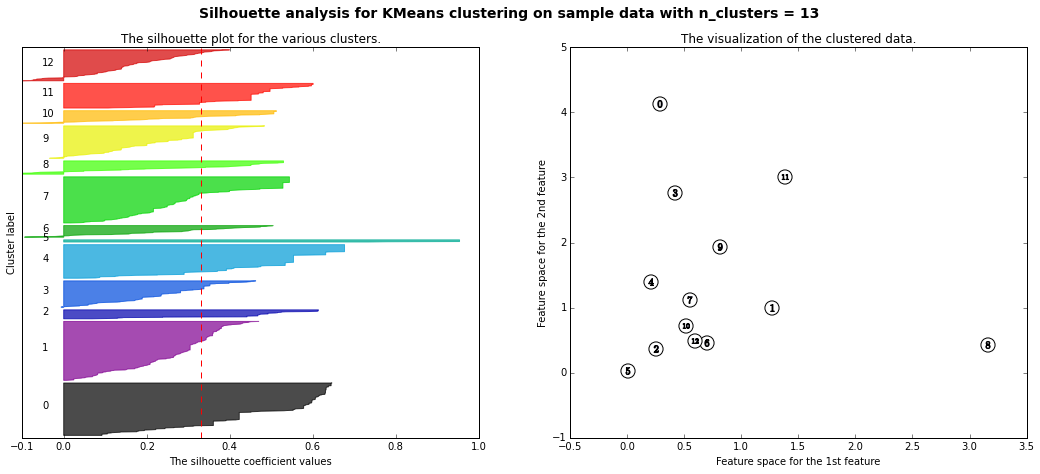

('For n_clusters =', 14, 'The average silhouette_score is :', 0.32017952937676664)


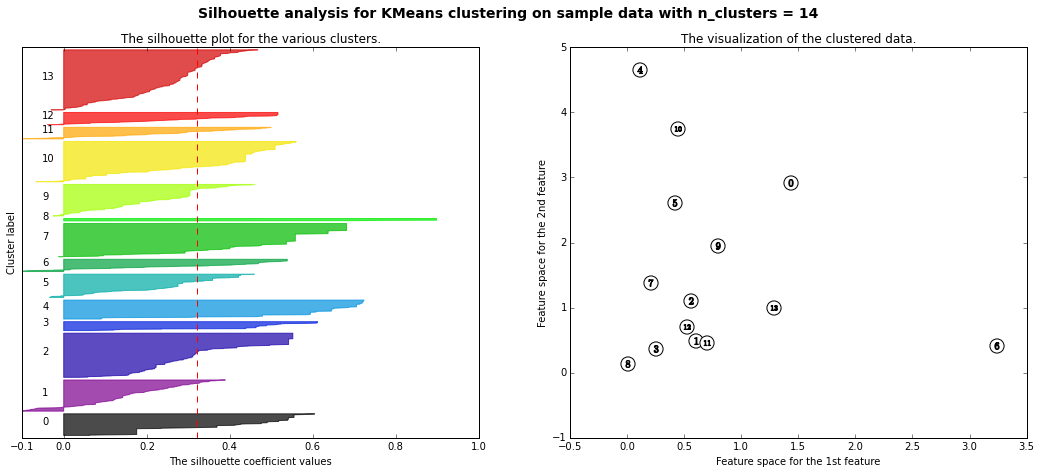

('For n_clusters =', 15, 'The average silhouette_score is :', 0.33211137242828198)


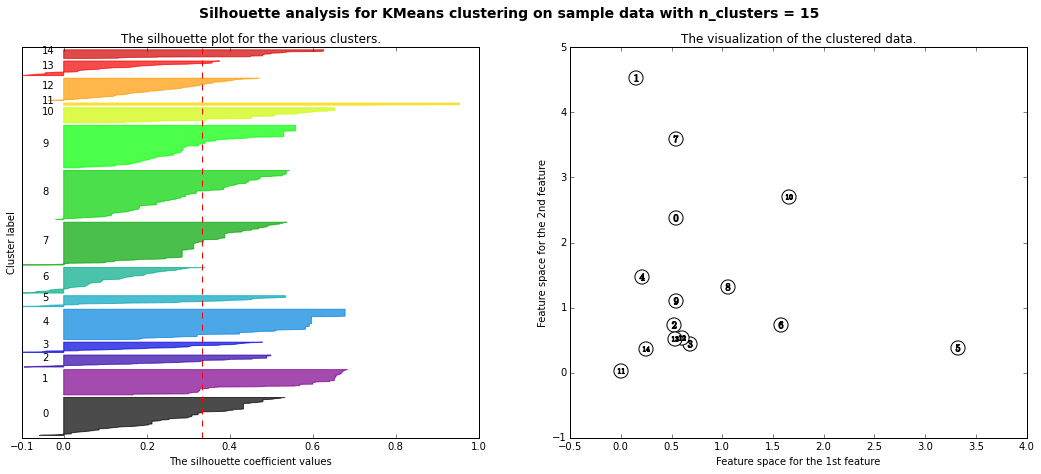

('For n_clusters =', 16, 'The average silhouette_score is :', 0.33264031863976923)


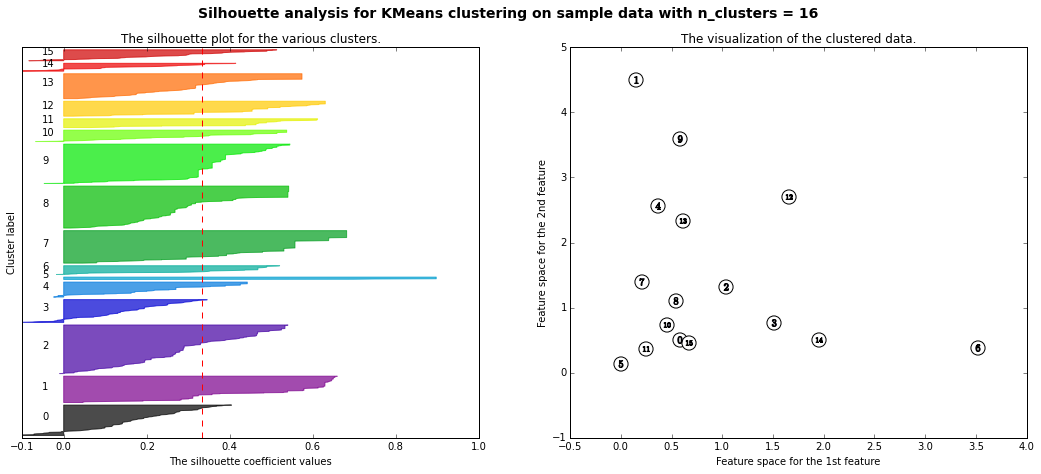

('For n_clusters =', 17, 'The average silhouette_score is :', 0.31714482742429917)


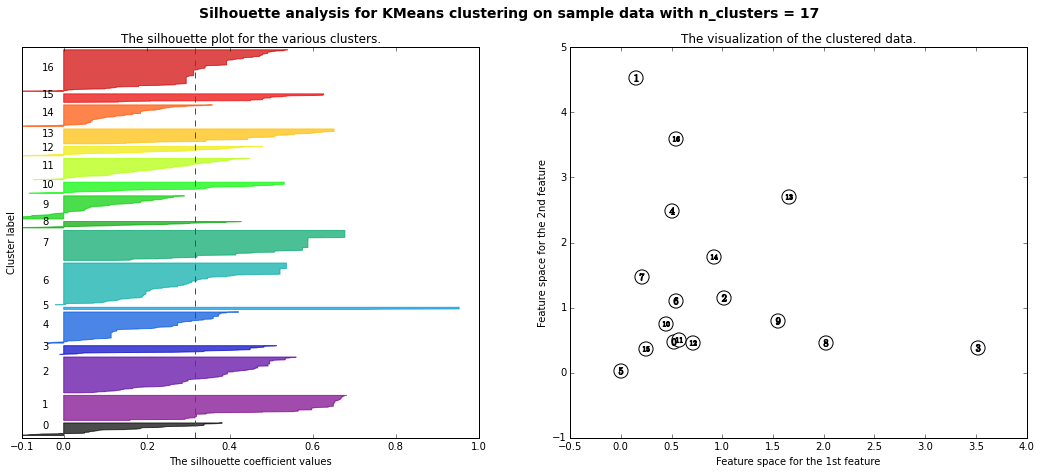

('For n_clusters =', 18, 'The average silhouette_score is :', 0.32749181727766219)


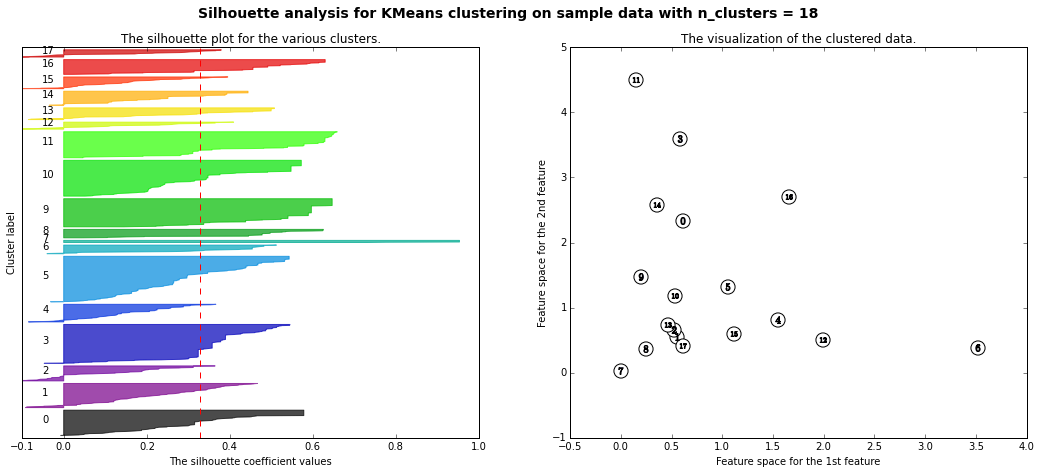

('For n_clusters =', 19, 'The average silhouette_score is :', 0.32316688701225771)


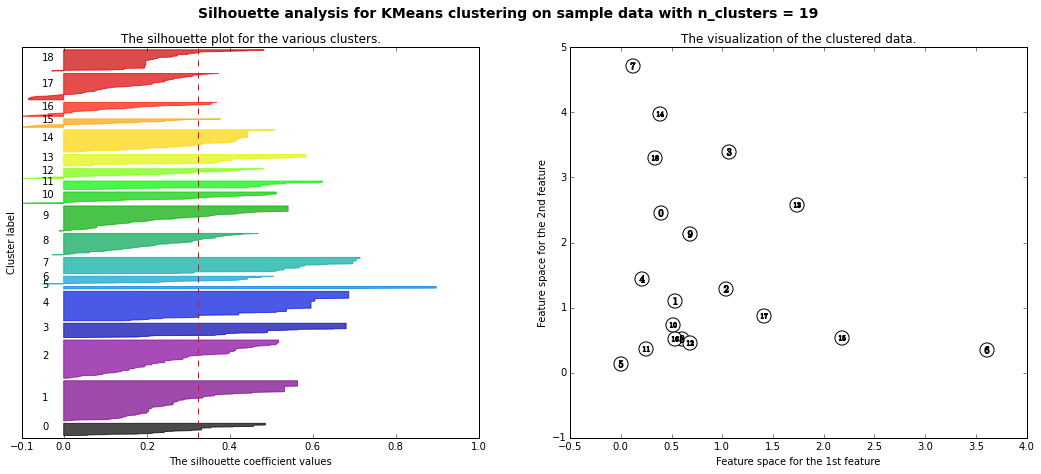

In [98]:
##First, combine the CO and the KO data
#Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean.loc[:,(dayList)])

#Run silhoette analysis on a range of cluster options
#silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(15,19,1))
silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(2,20,1))


Here I am going with 10 clusters, but I have no actual good reason for that number yet. I tried (and failed) to get the code to spit out the silouette average score...so nabbed the value from the headers (lame)

In [99]:
#completely lame...hand-copied the silhouette scores from the figures
silAverage = [0.43, 0.37, 0.38, 0.40, 0.36, 0.32]

(-1, 20)

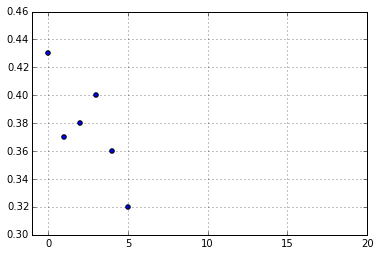

In [100]:
plt.scatter(range(0,len(silAverage)), silAverage)
plt.grid() #put on a grid
plt.xlim(-1,20)

In [104]:
#setting # of clusters manually, also some good options with lower # of clusters I think
useClusters = 5

In [105]:
#do the K-means clustering with the final # of clusters
CcoClust=kmeanCluster(Combined_KO_CO_MeanNorm, useClusters) #was 18 

#this will result in a data frame with the kmeans cluster as an added column. Remember
#this will have RI numbers for the compounds

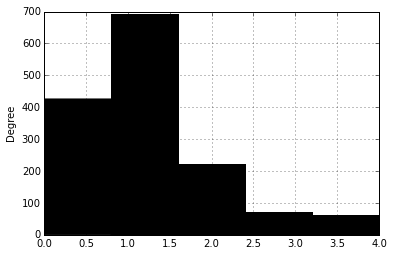

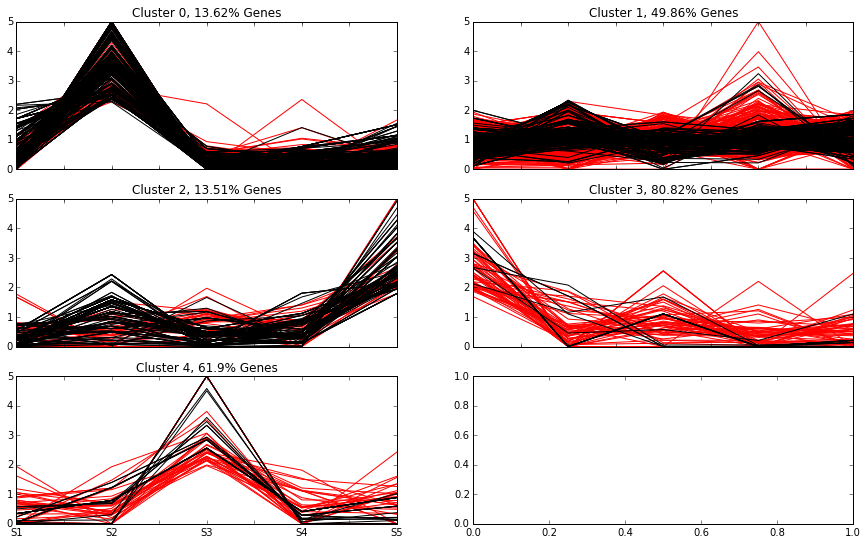

In [107]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        ax.set_title('Cluster ' + str(y)+ ', ' + str(round(KPct,2))+'% Genes')
    fig.savefig('CombinedKOandCO_Kmeans')

#PlotKmeansCombined(CcoClust,18,3,6, 'r') 
PlotKmeansCombined(CcoClust,useClusters,3,2, 'r') 

But...for the CheckRelatedness...do need to go back to the cNumber...for now, easiest to just make yet another matrix and put the cNumbers back in. 

In [108]:
forRelatedness = CcoClust.copy(deep=True) #make a copy of the CcoClust data frame
forRelatedness.insert(0,'KEGG',"") #add a column called 'KEGG'
forRelatedness.head(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
K17687,,0.471030,0.484041,1.538987,1.363316,1.142626,1
K00817,,1.631601,1.314645,0.814735,0.498653,0.740367,1
K17724,,2.438723,0.000000,2.561277,0.000000,0.000000,3
K06164,,1.941547,0.000000,3.058453,0.000000,0.000000,4
K03147,,0.813638,0.645428,0.402607,2.271505,0.866822,1


In [109]:
for idx in range(0,len(forRelatedness)):
    t = forRelatedness.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        forRelatedness.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness.ix[idx,('KEGG')] = t

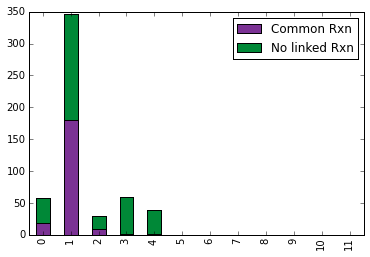

In [110]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        #i=kClust.index
        i = kClust.KEGG #change the new column I created with Cnumbers and Knumbers
        i=list(i)
        Csearc=re.compile('C.*') #re is regular expression...perl-like; re.compile bascially makes an object
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)
     
CheckRelatedness(forRelatedness, 12)

Seems like I want to plot the various CO/KO combined plots by clusters shown in the k-means clustering. Then, I can consider compounds within the same cluster.

In [111]:
makeSmall = forRelatedness[forRelatedness.kmeans==0]
#remember Python starts indexing at 0, so here I am checking out the first cluster.

In [112]:
makeSmall.tail(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
RI4914,C01212,0.235772,4.481927,0.121667,0.160634,0.000000,0
RI4916,C11974,0.000000,4.807304,0.119670,0.027584,0.045443,0
RI4917,C04145,0.289059,4.061332,0.557927,0.091682,0.000000,0
RI4925,C06218,0.272679,2.745732,0.411982,0.538033,1.031575,0
RI4931,C06218,0.272679,2.745732,0.411982,0.538033,1.031575,0


In [113]:
#for plotting, only need the rows with the cNumbers...
tData = []
for a in range(0,len(makeSmall)):
    m = makeSmall.index[a]
    if m[0] in 'RI':
        #keep the index and use to slice makeSmall
        tData.append(makeSmall.index[a])

In [114]:
#use tData (list of RI numbers) to shrinkg useSmall to the rows I want here
useSmall = makeSmall.loc[tData,:]

In [115]:
#example to start with: multiple RI numbers
CO = 'C18218'
# example to start with: single RI number
# CO = 'C00314'

Here...make a single figure to make sure I get it all right. Change to loop later.

In [116]:
#there will be multiple (and varied) related KOs and COs
kos=CO_withKO[CO]['Related KO']
cos=CO_withKO[CO]['Related CO'] 

In [117]:
#the kData are easy to process
for k in kos: 
    if k in KO_RawData.index: 
        kData=KO_RawData.loc[kos].dropna()
        kData=(kData.T/kData.sum(axis=1)).T


cData is a bit harder..write a couple of functions to switch bw RInumber and COnumber

In [118]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut

##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

In [119]:
def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['KEGG']
    return dataOut

##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2') 

In [120]:
#match the cos here with the RInumbers I generated
tData = [];
for c in cos:
    m = findRInumber(forRelatedness,c)
    if len(m)!=0: #seems dumb, looking for an isempty equivalent since I don't want the nones here
        tData.append(m)

In [121]:
#flatten the list...since I don't need the different groups generated by the previous cell
tData = list(chain.from_iterable(tData))

In [122]:
cData=CO_RawData_pruned.loc[tData].dropna()
cData=(cData.T/cData.sum(axis=1)).T
cData

,S1,S2,S3,S4,S5
RInumber,,,,,
RI3501,0.071830,0.615324,0.038217,0.097761,0.176868
RI3350,0.028633,0.947349,0.006144,0.006841,0.011034


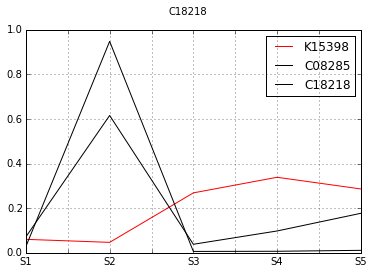

In [123]:
fig, ax=plt.subplots(1)
kData.T.plot(color='r', ax=ax)
cData.T.plot(color='k', ax=ax)

handles, labels = ax.get_legend_handles_labels()
#convert the RI numbers to COnumbers for the figure
for i, a in enumerate(labels):
    if a[0]=='R':
        m = convertRItoCO(forRelatedness,a)
        labels[i] = m
        #print i, m
        
ax.legend(handles, labels)        
fig.suptitle(CO)
#fig.savefig(CO+'.png')

Not sure we want the raw data here...the clustering is all based on normalized data, so let's try plotting that:

In [124]:
#the kData are easy to process
for k in kos: 
    if k in CcoClust.index: 
        kData=CcoClust.ix[kos,dayList].dropna()
        kData=(kData.T/kData.sum(axis=1)).T

In [125]:
#match the cos here with the RInumbers I generated
tData = [];
for c in cos:
    m = findRInumber(forRelatedness,c)
    if len(m)!=0: #seems dumb, looking for an isempty equivalent since I don't want the nones here
        tData.append(m)

#flatten the list...since I don't need the different groups generated by the previous cell
tData = list(chain.from_iterable(tData))

In [126]:
cData=CcoClust.ix[tData,dayList].dropna()
cData=(cData.T/cData.sum(axis=1)).T
cData

,S1,S2,S3,S4,S5
RI3501,0.071830,0.615324,0.038217,0.097761,0.176868
RI3350,0.028633,0.947349,0.006144,0.006841,0.011034


first up..., get the data, then perhaps define a plotting function?

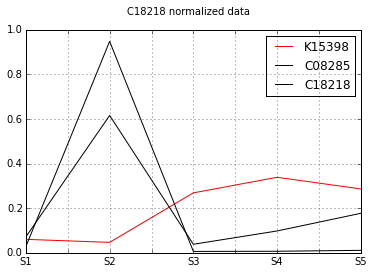

In [127]:


fig, ax=plt.subplots(1)
kData.T.plot(color='r', ax=ax)
cData.T.plot(color='k', ax=ax)

handles, labels = ax.get_legend_handles_labels()
#convert the RI numbers to COnumbers for the figure
for i, a in enumerate(labels):
    if a[0]=='R':
        m = convertRItoCO(forRelatedness,a)
        labels[i] = m
        #print i, m
        
ax.legend(handles, labels)        
fig.suptitle(CO + ' normalized data')
#fig.savefig(CO+'.png')



So, will have cases where the compounds from a cluster will not have corresponding pattern in genes. Perhaps look for correlations?

But...first make the plot generating thing a loop

start by just trying this with one Kmeans cluster

In [128]:
CcoClust.head(5)

,S1,S2,S3,S4,S5,kmeans
K17687,0.471030,0.484041,1.538987,1.363316,1.142626,1
K00817,1.631601,1.314645,0.814735,0.498653,0.740367,1
K17724,2.438723,0.000000,2.561277,0.000000,0.000000,3
K06164,1.941547,0.000000,3.058453,0.000000,0.000000,4
K03147,0.813638,0.645428,0.402607,2.271505,0.866822,1


In [129]:
m = str(CcoClust.ix[1,'kmeans'])

In [130]:
m.rstrip('.0')

'1'

In [131]:
def convertRItoCO2(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

In [132]:
for i,RI in enumerate(CcoClust.index):
    if RI[0] == 'R':
        #have an RInumber, go get the Cnumber
        CO = convertRItoCO2(CO_fromMATLAB,RI)
        #print CO

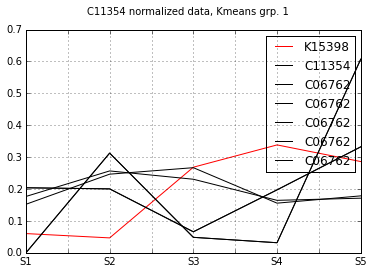

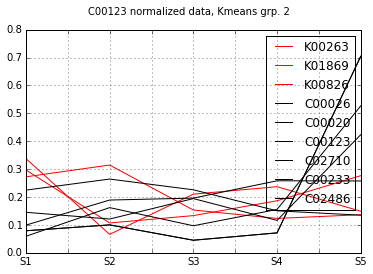

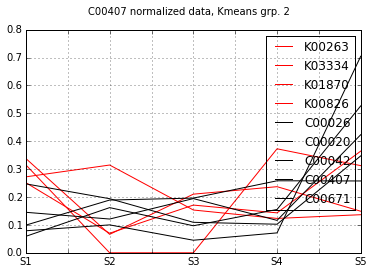

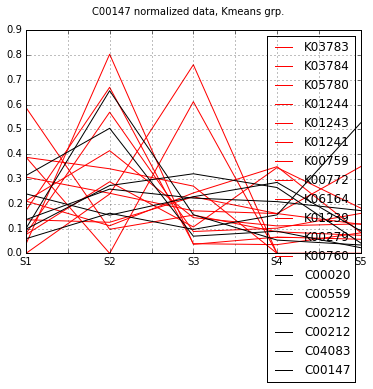

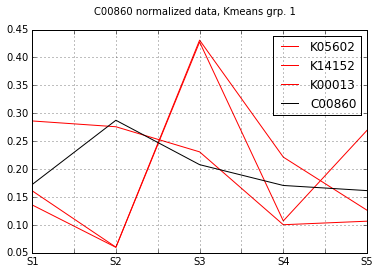

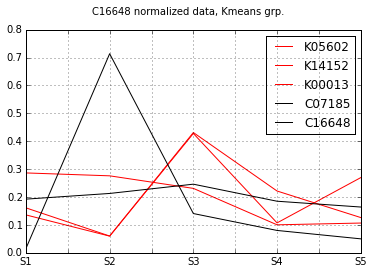

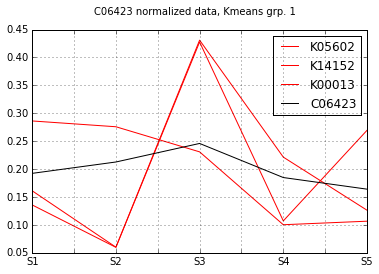

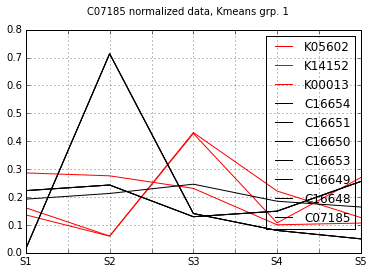

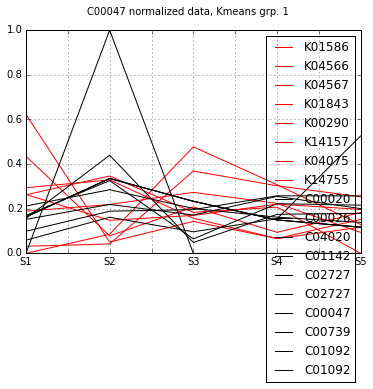

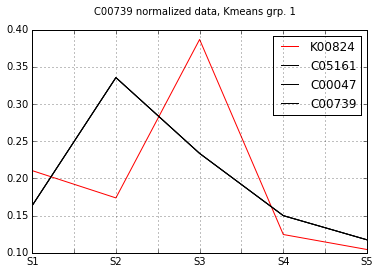

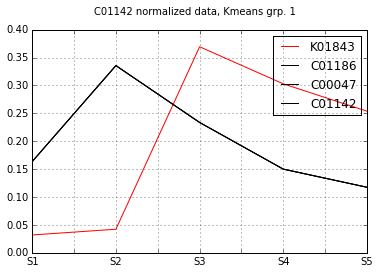

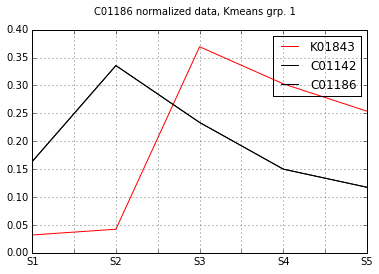

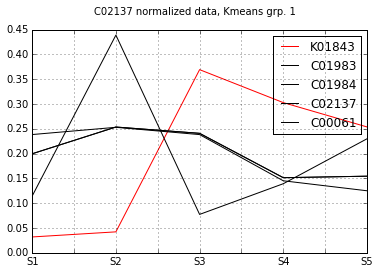

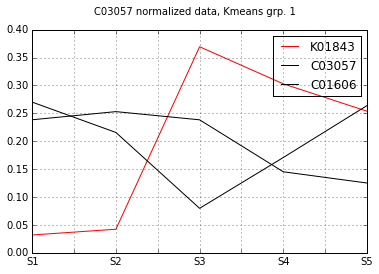

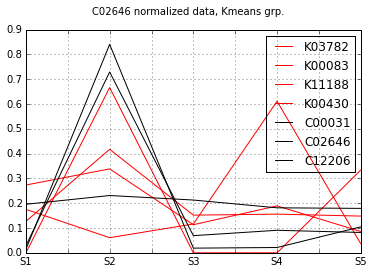

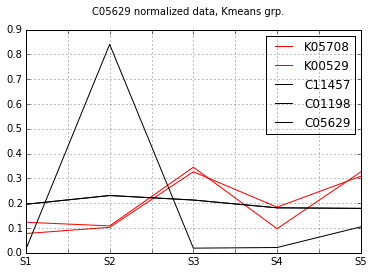

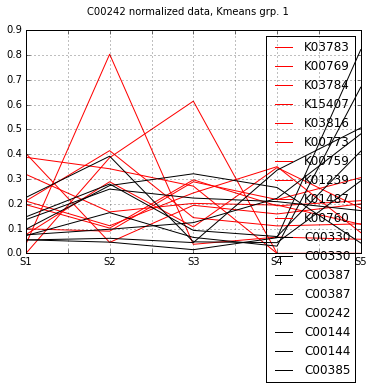

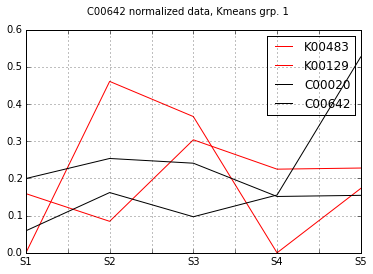

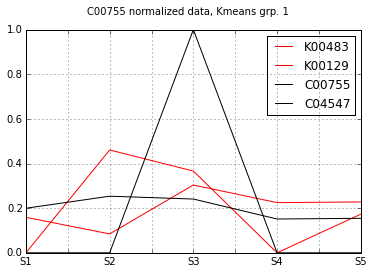

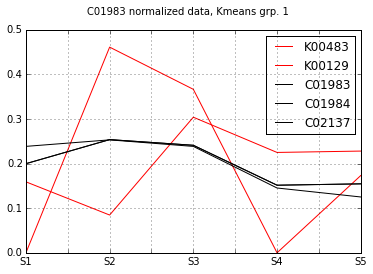

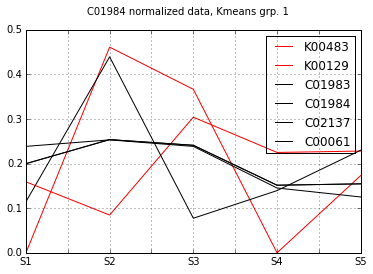

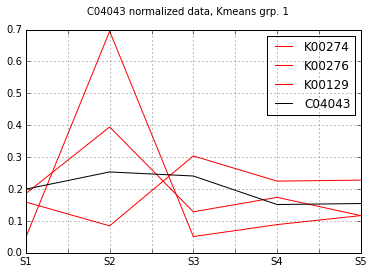

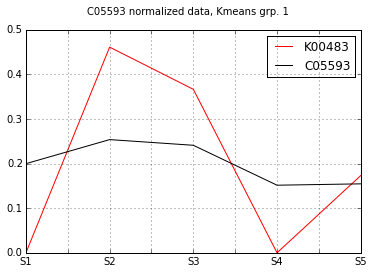

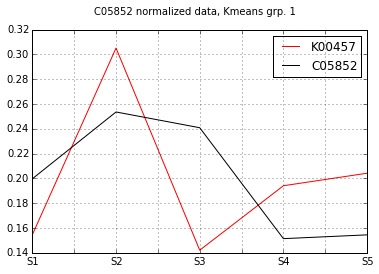

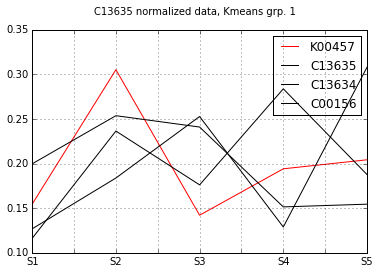

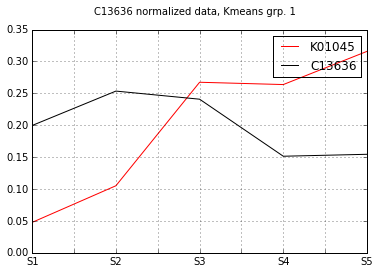

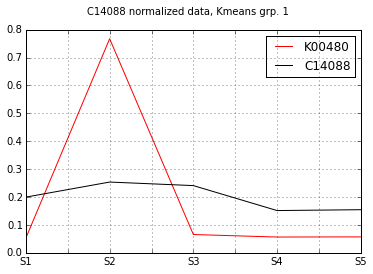

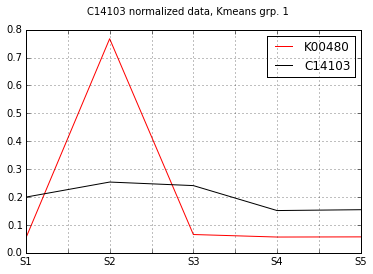

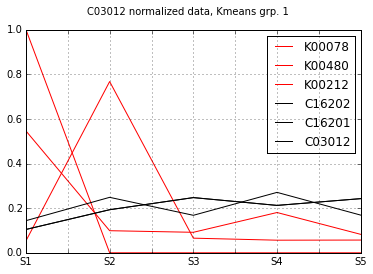

In [133]:
noMatch = []
counter = 1 #use this to only make one plot
for i,RI in enumerate(CcoClust.index):
    if counter < 30:
        if RI[0] == 'R':
            #have an RInumber, go get the Cnumber
            CO = convertRItoCO2(CO_fromMATLAB,RI)
            
            #pull the Kmeans group for the title [presumably there is a one-liner for this]
            m = str(CcoClust.ix[i, 'kmeans'])
            Kg = m.rstrip('.0')
            del m 
            
            #there will be multiple (and varied) related KOs and COs
            try:
                kos=CO_withKO[CO]['Related KO']
                cos=CO_withKO[CO]['Related CO'] 

                #the kData are easy to process
                for k in kos: 
                    if k in CcoClust.index: 
                        kData=CcoClust.ix[kos,dayList].dropna()
                        kData=(kData.T/kData.sum(axis=1)).T

                #match the cos here with the RInumbers I generated
                tData = [];
                for c in cos:
                    m = findRInumber(forRelatedness,c)
                    if len(m)!=0: #seems dumb, looking for an isempty equivalent since I don't want the nones here
                        tData.append(m)

                #flatten the list...since I don't need the different groups generated by the previous cell
                tData = list(chain.from_iterable(tData))

                cData=CcoClust.ix[tData,dayList].dropna()
                cData=(cData.T/cData.sum(axis=1)).T

                fig, ax=plt.subplots(1)
                kData.T.plot(color='r', ax=ax)
                cData.T.plot(color='k', ax=ax)

                handles, labels = ax.get_legend_handles_labels()
                #convert the RI numbers to COnumbers for the figure
                for i, a in enumerate(labels):
                    if a[0]=='R':
                        m = convertRItoCO(forRelatedness,a)
                        labels[i] = m
                        #print i, m

                ax.legend(handles, labels)        
                fig.suptitle(CO + ' normalized data, Kmeans grp. ' + str(Kg))
                #fig.savefig(CO+'.png')
                counter = counter + 1
            except:
                #figure out later why some of these don't have a match
                noMatch.append(CO)

In [134]:
noMatch

['C01933',
 'C02378',
 'C02486',
 'C06103',
 'C16653',
 'C16654',
 'C06104',
 'C06762',
 'C05161',
 'C02519',
 'C12305']